In [61]:
import xgboost
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot
from xgboost import plot_importance
from pymlx import *

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [62]:
ndre_data = pd.read_csv('../HydroSatML/data/final_join_subbed_missing_soilM.csv')
ndre_data_sub = pd.read_csv('../HydroSatML/data/final_join_subbed_bare_soil.csv')

In [63]:
ndre_data_sub.columns

Index(['field', 'average_adjacent', 'stdev_adjacent', 'sensor', 'date',
       'sensor_full_name', 'depth_1', 'depth_2', 'depth_3', 'precip.cm',
       'tair.C', 'rh.pct', 'wind_sp.m_per_s', 'irradiance.w_per_m.2', 'year',
       'sand_1', 'sand_2', 'sand_3', 'silt_1', 'silt_2', 'silt_3', 'clay_1',
       'clay_2', 'clay_3', 'avg_soilM'],
      dtype='object')

In [64]:
# keep_cols = ['avg_soilM', 'average_adjacent', 'precip.cm', 'tair.C', 'rh.pct', 'wind_sp.m_per_s', 
#              'irradiance.w_per_m.2', 'sand_1', 'sand_2', 'sand_3', 'silt_1', 'silt_2', 'silt_3', 'clay_1', 
#              'clay_2', 'clay_3']
keep_cols = ['avg_soilM', 'average_adjacent', 'precip.cm', 'tair.C', 'rh.pct', 'wind_sp.m_per_s', 
             'irradiance.w_per_m.2', 'sand_1', 'sand_2', 'sand_3', 'silt_1', 'silt_2', 'silt_3', 'clay_1', 
             'clay_2', 'clay_3']

In [65]:
dataset = ndre_data_sub[keep_cols]

In [66]:
# dataset

In [67]:
X = dataset.iloc[:,1:]
X = X.values

y = dataset.iloc[:,0]
y = y.values

In [71]:
# split data into train and test sets
seed = 7
test_size = 0.15
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

#### normalize

In [72]:
mean_X = X_train.mean(axis=0)
std_X = X_train.std(axis=0)

X_train = (X_train - mean_X) / std_X
X_test = (X_test - mean_X) / std_X

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

mean_y = y_train.mean(axis=0)
std_y = y_train.std(axis=0)

y_train = (y_train - mean_y) / std_y
y_test = (y_test - mean_y) / std_y

y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

In [73]:
print(X_train.shape)
print(X_test.shape)
print('')
print(y_train.shape)
print(y_test.shape)

(420, 15)
(75, 15)

(420,)
(75,)


In [ ]:
np.seed(0)

def xgbmodel():
    

In [119]:
def compute_mae(model, x, y):
    forecasts = model.predict(x)
#     forecasts = forecasts.reshape(forecasts.shape[0],dense)
    forecasts = (forecasts * std_y) + mean_y
    y_denom = (y * std_y) + mean_y
    result = mean_absolute_error(y_pred=forecasts, y_true=y_denom)
    return result

def compute_mape_centerScale(model, x, y):
    forecasts = model.predict(x)
#     forecasts = forecasts.reshape(forecasts.shape[0],dense)
    forecasts = (forecasts * std_y) + mean_y
    y_denom = (y * std_y) + mean_y
    sub_result = np.abs((y_denom - forecasts) / y_denom )
    # remove rows that are divided by 0 or a very small number
#     idxinf = np.where(sub_result == np.inf)
#     idx = np.where(sub_result > 1)
#     total_remove = len(idxinf[0]) + len(idx[0])
    #print('Removed %f percent of the data, a total of %d rows.'% (((total_remove/len(forecasts))*100), total_remove))
#     sub_result = np.delete(sub_result, idxinf[0],0)
#     sub_result = np.delete(sub_result, idx[0], 0)
    result = (np.mean(sub_result))
    return result


In [125]:
model = XGBRegressor()

n_estimators = range(50, 5000, 50)
max_depth = range(1,15,1)
learning_rate = [10**k for k in range(-5, -1)]
min_child_weight = range(1,15,1)
gamma = np.arange(0,1,0.001)
subsample = np.arange(0,1.1,.1)
colsample_bytree = np.arange(0.5,1,0.01)


param_grid = dict(n_estimators = n_estimators,
                  max_depth = max_depth,
                  min_child_weight = min_child_weight,
                  gamma = gamma,
                  learning_rate = learning_rate,
                  subsample = subsample,
                  colsample_bytree = colsample_bytree)

start_timing()
sweeper = random_sweep(
    X_train, y_train, 
    model, param_grid,
    scoring=compute_mape_centerScale, 
    n_iter=1000, n_jobs=7, refit=False, cv=3, verbose=1)
report_timing()

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=7)]: Done  36 tasks      | elapsed:    6.2s
[Parallel(n_jobs=7)]: Done 186 tasks      | elapsed:   27.4s
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed:  1.3min
[Parallel(n_jobs=7)]: Done 786 tasks      | elapsed:  2.6min
[Parallel(n_jobs=7)]: Done 1236 tasks      | elapsed:  4.6min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed:  7.0min
[Parallel(n_jobs=7)]: Done 2436 tasks      | elapsed:  9.9min


Elapsed: 12 minutes


[Parallel(n_jobs=7)]: Done 3000 out of 3000 | elapsed: 12.1min finished


In [126]:
sweep_stats(sweeper)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


,Score,Std,colsample_bytree,gamma,learning_rate,max_depth,min_child_weight,n_estimators,subsample
0,0.275675,0.017167,0.65,0.301,0.01000,11,5,3350,0.0
1,0.275675,0.017167,0.52,0.615,0.00001,10,11,1850,0.0
2,0.275675,0.017167,0.85,0.310,0.00010,13,1,3500,0.0
3,0.275675,0.017167,0.88,0.218,0.01000,10,1,3700,0.0
4,0.275675,0.017167,0.63,0.503,0.00010,5,10,600,0.0
5,0.275675,0.017167,0.86,0.258,0.00001,1,3,1300,0.0
6,0.275675,0.017167,0.65,0.901,0.00100,3,2,3650,0.0
7,0.275675,0.017167,0.51,0.311,0.01000,13,5,3800,0.0
8,0.275675,0.017167,0.75,0.739,0.00010,14,7,3000,0.0
9,0.275675,0.017167,0.96,0.029,0.01000,3,9,2950,0.0


In [130]:
model = XGBRegressor(colsample_bytree=0.64, gamma=0.05, learning_rate=0.01, max_depth=11, 
                     min_child_weight=9, n_estimators=4150, subsample=0.8)

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.64, gamma=0.05, learning_rate=0.01,
       max_delta_step=0, max_depth=11, min_child_weight=9, missing=None,
       n_estimators=4150, n_jobs=1, nthread=None, objective='reg:linear',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8)

In [76]:
X_test.shape
y_test.shape

(75, 15)

(75,)

In [131]:
# make predictions for test data
y_pred = model.predict(X_test)
y_pred_inv = (y_pred * std_y) + mean_y
y_test_inv = (y_test * std_y) + mean_y

# y_pred_inv
compute_mape_centerScale(model, X_test, y_test)
mean_absolute_error(y_pred=y_pred_inv, y_true=y_test_inv)

0.093625031

0.019413231

In [78]:
model.feature_importances_


array([ 0.18814814,  0.01333333,  0.08148148,  0.10222222,  0.09333333,
        0.11111111,  0.04592593,  0.0637037 ,  0.03703704,  0.06222222,
        0.04740741,  0.03555556,  0.03851852,  0.01777778,  0.06222222], dtype=float32)

In [30]:
# make predictions for test data
y_pred = model.predict(X_test)
y_pred_inv = (y_pred * std_y) + mean_y
y_test_inv = (y_test * std_y) + mean_y

# y_pred_inv

mean_absolute_error(y_pred=y_pred_inv, y_true=y_test_inv)

0.027840046

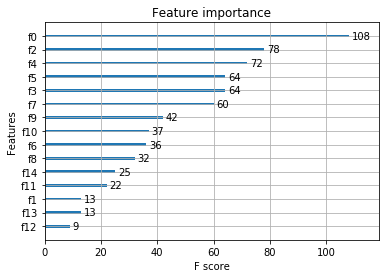

In [59]:
pyplot.figure(figsize=(16,1))
plot_importance(model)
pyplot.show()

In [19]:
dataset.columns

Index(['avg_soilM', 'average_adjacent', 'precip.cm', 'tair.C', 'rh.pct',
       'wind_sp.m_per_s', 'irradiance.w_per_m.2', 'sand_1', 'sand_2', 'sand_3',
       'silt_1', 'silt_2', 'silt_3', 'clay_1', 'clay_2', 'clay_3'],
      dtype='object')

In [ ]:
y_test_inv
y_pred_inv

In [ ]:
abs(min(y_test_inv) - max(y_test_inv))